In [1]:
import mistat
import statsmodels.formula.api as smf
from mistat.design import doe
import numpy as np
import pandas as pd
np.random.seed(2)

In [2]:
# factors = {
#   's': [0.01, 0.015],
#   'v0': [0.00625, 0.00875],
#   'k': [2000, 4000],
#   't0': [345, 355],
# }
# Design = doe.central_composite(factors, alpha='r', center=[4, 4])

# simulator = mistat.PistonSimulator(**Design, m=60, p0=110_000, t=296, 
#                                    n_replicate=5, seed=2)
# result = simulator.simulate()
# result

In [3]:
factors = {
  's': [0.01, 0.015],
  'v0': [0.00625, 0.00875],
  'k': [2000, 4000],
  't0': [345, 355],
}
Design = doe.central_composite(factors, alpha='r', center=[4, 4])

seed = 2
# seed = 1234
simulator = mistat.PistonSimulator(**Design, m=60, p0=110_000, t=296, 
                                   n_replicate=5, seed=seed)
result = simulator.simulate()
result

,m,s,v0,k,p0,t,t0,seconds,group
0,60,0.0100,0.00625,2000.0,110000,296,345.0,0.060226,1
1,60,0.0100,0.00625,2000.0,110000,296,345.0,0.065020,1
2,60,0.0100,0.00625,2000.0,110000,296,345.0,0.057302,1
3,60,0.0100,0.00625,2000.0,110000,296,345.0,0.050978,1
4,60,0.0100,0.00625,2000.0,110000,296,345.0,0.056526,1
...,...,...,...,...,...,...,...,...,...
155,60,0.0125,0.00750,3000.0,110000,296,350.0,0.068963,32
156,60,0.0125,0.00750,3000.0,110000,296,350.0,0.051328,32
157,60,0.0125,0.00750,3000.0,110000,296,350.0,0.051373,32
158,60,0.0125,0.00750,3000.0,110000,296,350.0,0.059050,32


In [4]:
# transformation between factors and code levels
factor2x = {factor: f'x{i}' for i, factor in enumerate(factors, 1)}
x2factor = {f'x{i}': factor for i, factor in enumerate(factors, 1)}
center = {factor: 0.5 * (max(values) + min(values))
          for factor, values in factors.items()}
unit = {factor: 0.5 * (max(values) - min(values))
        for factor, values in factors.items()}

# define helper function to convert code co-ordinates to factor co-ordinates
def toFactor(code, codeValue):
    ''' convert code to factor co-ordinates '''
    factor = x2factor[code]
    return center[factor] + codeValue * unit[factor]

# add code levels to table
for c in factors:
    result[factor2x[c]] =  (result[c] - center[c]) / unit[c]
result[['seconds', 'group', 'x1', 'x2', 'x3', 'x4']].to_csv('ccd-bootstrap.csv')

In [5]:
def buildModel(df, formula=None):
    formula = ('seconds ~ (x1+x2+x3+x4)**2 + ' +
               'I(x1**2) + I(x2**2) + I(x3**2) + I(x4**2)')
    formula = 'seconds ~ x1 + x2 + x3 + x1:x2+ x1:x3 + I(x1**2)'
#     formula = ('seconds ~ (x1+x2+x3+x4)')
#     formula = ('seconds ~ (x1+x2+x3)')
    formula = formula or ('seconds ~ (x1+x2+x3+x4)**2')
#     formula = ('seconds ~ (x1+x2+x3+x4) + I(x1**2) + I(x2**2) + I(x3**2) + I(x4**2)')
    model = smf.ols(formula, data=df).fit()
    return model
ols_model = buildModel(result)
buildModel(result).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                seconds   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     128.0
Date:                Mon, 28 Aug 2023   Prob (F-statistic):           4.99e-57
Time:                        13:38:43   Log-Likelihood:                 536.73
No. Observations:                 160   AIC:                            -1059.
Df Residuals:                     153   BIC:                            -1038.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0603      0.001     69.736      0.000       0.059       0.062
x1            -0.0155      0.001    -19.680      0.000      -0.017      -0.014
x2             0.0130      0.001     16.498      0.000       0.011       0.015
x3             0.0047      0.001      6.003      0.000       0.003       0.006
x1:x2         -0.0049      0.001     -5.082      0.000      -0.007      -0.003
x1:x3         -0.0023      0.001     -2.362      0.019      -0.004      -0.000
I(x1 ** 2)     0.0045      0.001      6.395      0.000       0.003       0.006
==============================================================================
Omnibus:                        5.101   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                4.785
Skew:                           0.329   Prob(JB):                       0.0914
Kurtosis:                       3.532   Cond. No.                         2.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
group = ['x1', 'x2', 'x3', 'x4']
resample_BBA = pd.DataFrame([buildModel(result.groupby(group).sample(frac=1, replace=True)).params for _ in range(100)])
resample_BBA.agg(['mean', 'std'])

,Intercept,x1,x2,x3,x1:x2,x1:x3,I(x1 ** 2)
mean,0.060195,-0.015524,0.012957,0.004715,-0.004826,-0.002269,0.004572
std,0.000763,0.000722,0.000649,0.000686,0.000836,0.000883,0.000668


In [7]:
resample_BA = pd.DataFrame([buildModel(result.sample(frac=1, replace=True)).params for _ in range(100)])
resample_BA.agg(['mean', 'std'])

,Intercept,x1,x2,x3,x1:x2,x1:x3,I(x1 ** 2)
mean,0.060267,-0.015652,0.01303,0.004703,-0.004937,-0.002293,0.004612
std,0.000883,0.000935,0.00077,0.000796,0.001016,0.001032,0.000843


In [8]:
buildModel(result).summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.827     
Dependent Variable: seconds          AIC:                -1059.4506
Date:               2023-08-28 13:38 BIC:                -1037.9244
No. Observations:   160              Log-Likelihood:     536.73    
Df Model:           6                F-statistic:        128.0     
Df Residuals:       153              Prob (F-statistic): 4.99e-57  
R-squared:          0.834            Scale:              7.4687e-05
--------------------------------------------------------------------
                Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept       0.0603    0.0009   69.7364  0.0000   0.0586   0.0620
x1             -0.0155    0.0008  -19.6796  0.0000  -0.0171  -0.0140
x2              0.0130    0.0008   16.4975  0.0000   0.0115   0.0146
x3              0.0047    0.0008    6.0026  0.0000   0.0032   0.0063
x1:x2          -0.0049    0.0010   -5.0818  0.0000  -0.0068  -0.0030
x1:x3          -0.0023    0.0010   -2.3618  0.0194  -0.0042  -0.0004
I(x1 ** 2)      0.0045    0.0007    6.3953  0.0000   0.0031   0.0059
-------------------------------------------------------------------
Omnibus:                5.101        Durbin-Watson:           1.870
Prob(Omnibus):          0.078        Jarque-Bera (JB):        4.785
Skew:                   0.329        Prob(JB):                0.091
Kurtosis:               3.532        Condition No.:           2    
===================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors
is correctly specified.
"""

(0.0, 0.0013)

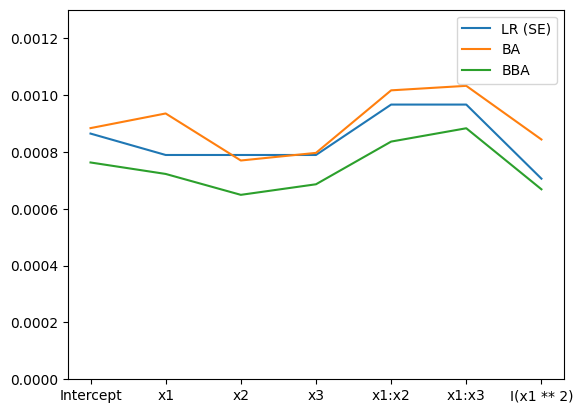

In [9]:
# resample_BA.agg(['mean', 'std']).transpose()
ax = pd.DataFrame({
    'LR (SE)': buildModel(result).bse, #*np.sqrt(5),
    'BA': resample_BA.agg(['mean', 'std']).transpose()['std'],
    'BBA': resample_BBA.agg(['mean', 'std']).transpose()['std'],
}).plot()
ax.set_ylim(0, 0.0013)

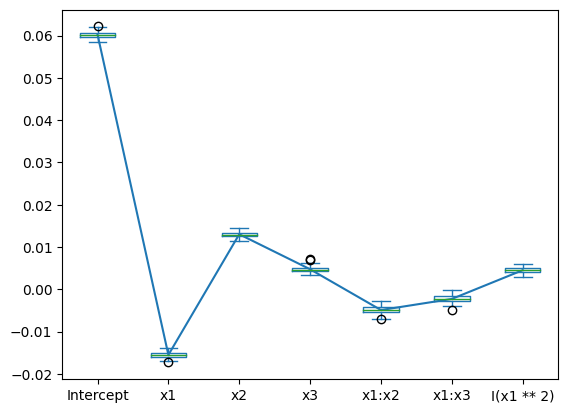

In [10]:
ax = resample_BBA.plot.box()
ax.plot([x+1 for x in range(len(ols_model.params))], ols_model.params)

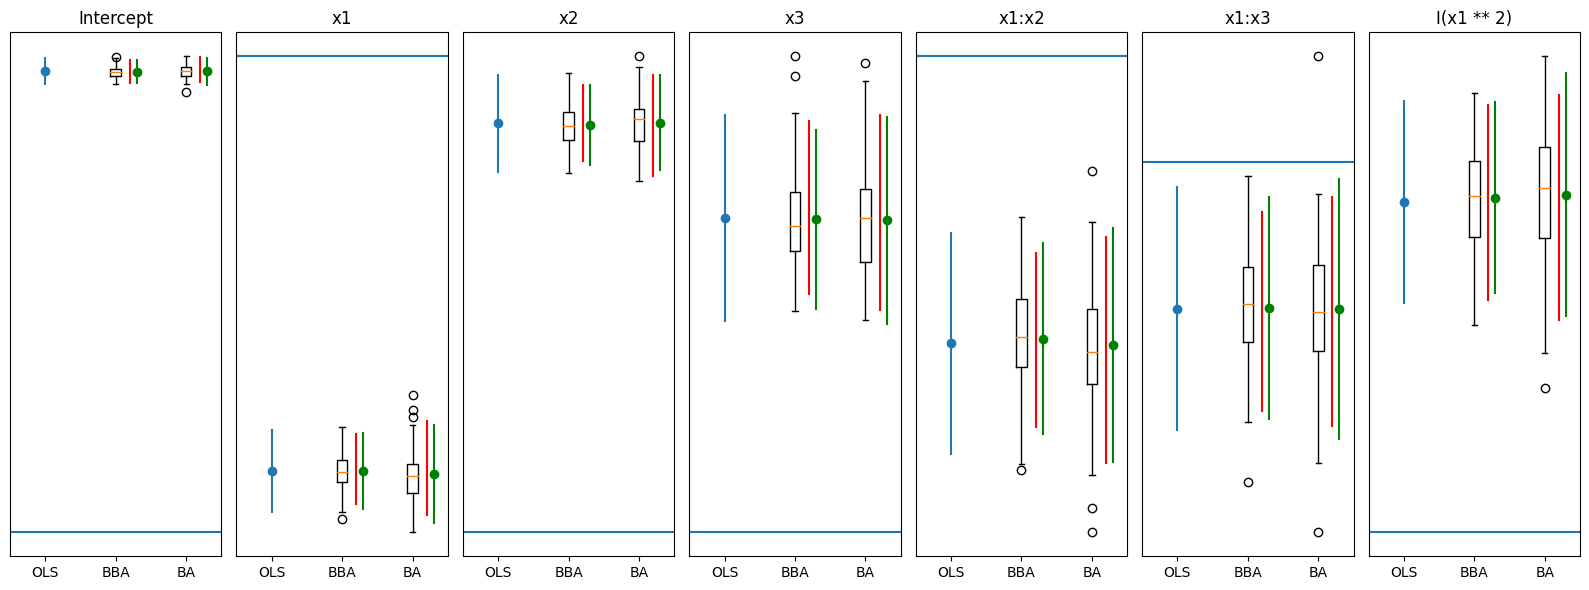

In [11]:
import itertools

terms = list(ols_model.params.index)
import matplotlib.pyplot as plt
# fig, axes = plt.subplots(ncols=len(terms) // 2, nrows=2, figsize=[16, 6])
fig, axes = plt.subplots(ncols=len(terms), nrows=1, figsize=[16, 6])
# for ax, term in zip(itertools.chain(*axes), terms):
for ax, term in zip(axes, terms):
    ax.plot([0, 0], [ols_model.params[term] - 1.96*ols_model.bse[term], ols_model.params[term] + 1.96*ols_model.bse[term]])
    ax.scatter(0, ols_model.params[term], )
    ax.boxplot([resample_BBA[term], resample_BA[term]])
    ax.plot([1.2, 1.2], resample_BBA[term].quantile([0.025, 0.975]), color='red')
    ax.plot([2.2, 2.2], resample_BA[term].quantile([0.025, 0.975]), color='red')
    m = resample_BBA[term].mean()
    s = resample_BBA[term].std() * 1.96
    ax.plot([1.3, 1.3], [m+s, m-s], color='green')
    ax.scatter(1.3, m, color='green')
    m = resample_BA[term].mean()
    s = resample_BA[term].std() * 1.96
    ax.plot([2.3, 2.3], [m+s, m-s], color='green')
    ax.scatter(2.3, m, color='green')
    ax.set_title(term)
    ax.get_yaxis().set_visible(False)
    ax.set_xticks([0, 1, 2], ['OLS', 'BBA', 'BA'])
    ax.set_xlim(-0.5, 2.5)
    ax.axhline(0)
plt.tight_layout()
plt.show()

In [12]:
formula = 'seconds ~ x1+x2+x3+x4'
formula_int = 'seconds ~ (x1+x2+x3+x4)**2'
formula_full = 'seconds ~ (x1+x2+x3+x4)**2 +I(x1**2) +I(x2**2) +I(x3**2) +I(x4**2)'
formula_quadratic = 'seconds ~ x1+x2+x3+x4 +I(x1**2) +I(x2**2) +I(x3**2) +I(x4**2)'

model_noint = buildModel(result, formula)
model_int = buildModel(result, formula_int)
model_full = buildModel(result, formula_full)
model_quadratic = buildModel(result, formula_quadratic)

In [13]:
group = ['x1', 'x2', 'x3', 'x4']
resample_BBA = pd.DataFrame([buildModel(result.groupby(group).sample(frac=1, replace=True), formula).params for _ in range(100)])
resample_BBA.agg(['mean', 'std'])
resample_BBA_int = pd.DataFrame([buildModel(result.groupby(group).sample(frac=1, replace=True), formula_int).params for _ in range(100)])
resample_BBA_int.agg(['mean', 'std'])
resample_BBA_full = pd.DataFrame([buildModel(result.groupby(group).sample(frac=1, replace=True), formula_full).params for _ in range(100)])
resample_BBA_full.agg(['mean', 'std'])
resample_BBA_quadratic = pd.DataFrame([buildModel(result.groupby(group).sample(frac=1, replace=True), formula_quadratic).params for _ in range(100)])
resample_BBA_quadratic.agg(['mean', 'std'])

,Intercept,x1,x2,x3,x1:x2,x1:x3,I(x1 ** 2)
mean,0.060157,-0.015572,0.012983,0.004667,-0.004791,-0.002188,0.004531
std,0.000736,0.000755,0.000629,0.000675,0.000894,0.000911,0.000707


In [14]:
resample_BA = pd.DataFrame([buildModel(result.sample(frac=1, replace=True), formula).params for _ in range(100)])
resample_BA.agg(['mean', 'std'])
resample_BA_int = pd.DataFrame([buildModel(result.sample(frac=1, replace=True), formula_int).params for _ in range(100)])
resample_BA_int.agg(['mean', 'std'])
resample_BA_full = pd.DataFrame([buildModel(result.sample(frac=1, replace=True), formula_full).params for _ in range(100)])
resample_BA_full.agg(['mean', 'std'])
resample_BA_quadratic = pd.DataFrame([buildModel(result.sample(frac=1, replace=True), formula_quadratic).params for _ in range(100)])
resample_BA_quadratic.agg(['mean', 'std'])

,Intercept,x1,x2,x3,x1:x2,x1:x3,I(x1 ** 2)
mean,0.060251,-0.015448,0.013098,0.004647,-0.004900,-0.002268,0.004523
std,0.000910,0.000895,0.000925,0.000793,0.000984,0.000980,0.000665


In [15]:
def calculate_Delta(model, resample):
    table = pd.DataFrame({
    'Regr.': model.bse,
    'Bootstrap': resample.agg(['std']).transpose()['std'],
    })
    table['Delta'] = (100*(table['Bootstrap'] / table['Regr.'] - 1)).round(1)
    return table

comp_BA = pd.concat([
    calculate_Delta(model_noint, resample_BA),
#     calculate_Delta(model_int, resample_BA_int),
#     calculate_Delta(model_full, resample_BA_full),
    calculate_Delta(model_quadratic, resample_BA_quadratic),    
], axis=1)

In [16]:
comp_BBA = pd.concat([
    calculate_Delta(model_noint, resample_BBA),
#     calculate_Delta(model_int, resample_BBA_int),
#     calculate_Delta(model_full, resample_BBA_full),
    calculate_Delta(model_quadratic, resample_BBA_quadratic),
], axis=1)

In [17]:
pd.concat({
    'BA': comp_BA,
    'BBA': comp_BBA
}, axis=1)

BA                                                 BBA  \
               Regr. Bootstrap Delta     Regr. Bootstrap Delta     Regr.   
Intercept   0.000864  0.000835  -3.4  0.000864  0.000910   5.3  0.000864   
x1          0.000789  0.000975  23.6  0.000789  0.000895  13.5  0.000789   
x2          0.000789  0.000790   0.1  0.000789  0.000925  17.3  0.000789   
x3          0.000789  0.000665 -15.7  0.000789  0.000793   0.5  0.000789   
x1:x2       0.000966  0.000976   1.0  0.000966  0.000984   1.9  0.000966   
x1:x3       0.000966  0.000947  -2.0  0.000966  0.000980   1.4  0.000966   
I(x1 ** 2)  0.000706  0.000898  27.2  0.000706  0.000665  -5.7  0.000706   

                                                      
           Bootstrap Delta     Regr. Bootstrap Delta  
Intercept   0.000748 -13.4  0.000864  0.000736 -14.8  
x1          0.000965  22.4  0.000789  0.000755  -4.3  
x2          0.000668 -15.3  0.000789  0.000629 -20.3  
x3          0.000790   0.2  0.000789  0.000675 -14.4  
x1:x2       0.000910  -5.8  0.000966  0.000894  -7.5  
x1:x3       0.000956  -1.0  0.000966  0.000911  -5.7  
I(x1 ** 2)  0.000743   5.3  0.000706  0.000707   0.2

# Parametric bootstrap

In [18]:
from scipy import stats
rng = np.random.default_rng(seed=123)

def parametricBootstrap(df, outcome=None, rng=None):
    df = df.copy()
    y = df[outcome]
    
    resample = stats.norm.rvs(loc=np.mean(y), scale=np.std(y), size=len(y),
                                   random_state=rng)
    df[outcome] = resample
    return df


result.groupby(group).apply(parametricBootstrap, outcome='seconds').reset_index(drop=True)

,m,s,v0,k,p0,t,t0,seconds,group,x1,x2,x3,x4
0,60,0.0075,0.0075,3000.0,110000,296,350.0,0.106700,21,-2.0,0.0,0.0,0.0
1,60,0.0075,0.0075,3000.0,110000,296,350.0,0.104755,21,-2.0,0.0,0.0,0.0
2,60,0.0075,0.0075,3000.0,110000,296,350.0,0.121469,21,-2.0,0.0,0.0,0.0
3,60,0.0075,0.0075,3000.0,110000,296,350.0,0.136467,21,-2.0,0.0,0.0,0.0
4,60,0.0075,0.0075,3000.0,110000,296,350.0,0.099436,21,-2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,60,0.0175,0.0075,3000.0,110000,296,350.0,0.042909,22,2.0,0.0,0.0,0.0
156,60,0.0175,0.0075,3000.0,110000,296,350.0,0.043346,22,2.0,0.0,0.0,0.0
157,60,0.0175,0.0075,3000.0,110000,296,350.0,0.042225,22,2.0,0.0,0.0,0.0
158,60,0.0175,0.0075,3000.0,110000,296,350.0,0.039582,22,2.0,0.0,0.0,0.0


In [19]:
resample_pBBA = pd.DataFrame([buildModel(result.groupby(group).apply(parametricBootstrap, outcome='seconds', rng=rng), formula).params for _ in range(100)])
resample_pBBA.agg(['mean', 'std'])
resample_pBBA_int = pd.DataFrame([buildModel(result.groupby(group).apply(parametricBootstrap, outcome='seconds', rng=rng), formula_int).params for _ in range(100)])
resample_pBBA_int.agg(['mean', 'std'])

,Intercept,x1,x2,x3,x1:x2,x1:x3,I(x1 ** 2)
mean,0.060340,-0.015525,0.013029,0.004712,-0.004890,-0.002297,0.004465
std,0.000815,0.000805,0.000685,0.000649,0.000901,0.000876,0.000686


In [20]:
resample_pBA = pd.DataFrame([buildModel(parametricBootstrap(result, outcome='seconds', rng=rng), formula).params for _ in range(100)])
resample_pBA.agg(['mean', 'std'])
resample_pBA_int = pd.DataFrame([buildModel(parametricBootstrap(result, outcome='seconds', rng=rng), formula_int).params for _ in range(100)])
resample_pBA_int.agg(['mean', 'std'])

,Intercept,x1,x2,x3,x1:x2,x1:x3,I(x1 ** 2)
mean,0.063533,-0.000159,0.000344,0.000142,-0.000136,0.000248,0.000087
std,0.002193,0.001937,0.002066,0.001963,0.002402,0.002297,0.001647


In [21]:
comp_pBA = pd.concat([
    calculate_Delta(model_noint, resample_pBA),
    calculate_Delta(model_int, resample_pBA_int)
], axis=1)
comp_pBBA = pd.concat([
    calculate_Delta(model_noint, resample_pBBA),
    calculate_Delta(model_int, resample_pBBA_int)
], axis=1)

pd.concat({
    'BA': comp_BA,
    'BBA': comp_BBA,
    'pBBA': comp_pBBA
}, axis=1)

BA                                                 BBA  \
               Regr. Bootstrap Delta     Regr. Bootstrap Delta     Regr.   
Intercept   0.000864  0.000835  -3.4  0.000864  0.000910   5.3  0.000864   
x1          0.000789  0.000975  23.6  0.000789  0.000895  13.5  0.000789   
x2          0.000789  0.000790   0.1  0.000789  0.000925  17.3  0.000789   
x3          0.000789  0.000665 -15.7  0.000789  0.000793   0.5  0.000789   
x1:x2       0.000966  0.000976   1.0  0.000966  0.000984   1.9  0.000966   
x1:x3       0.000966  0.000947  -2.0  0.000966  0.000980   1.4  0.000966   
I(x1 ** 2)  0.000706  0.000898  27.2  0.000706  0.000665  -5.7  0.000706   

                                                          pBBA            \
           Bootstrap Delta     Regr. Bootstrap Delta     Regr. Bootstrap   
Intercept   0.000748 -13.4  0.000864  0.000736 -14.8  0.000864  0.000701   
x1          0.000965  22.4  0.000789  0.000755  -4.3  0.000789  0.000801   
x2          0.000668 -15.3  0.000789  0.000629 -20.3  0.000789  0.000650   
x3          0.000790   0.2  0.000789  0.000675 -14.4  0.000789  0.000630   
x1:x2       0.000910  -5.8  0.000966  0.000894  -7.5  0.000966  0.000807   
x1:x3       0.000956  -1.0  0.000966  0.000911  -5.7  0.000966  0.000839   
I(x1 ** 2)  0.000743   5.3  0.000706  0.000707   0.2  0.000706  0.000701   

                                            
           Delta     Regr. Bootstrap Delta  
Intercept  -18.9  0.000864  0.000815  -5.6  
x1           1.6  0.000789  0.000805   2.1  
x2         -17.6  0.000789  0.000685 -13.2  
x3         -20.1  0.000789  0.000649 -17.7  
x1:x2      -16.4  0.000966  0.000901  -6.7  
x1:x3      -13.2  0.000966  0.000876  -9.4  
I(x1 ** 2)  -0.6  0.000706  0.000686  -2.8

<Axes: >

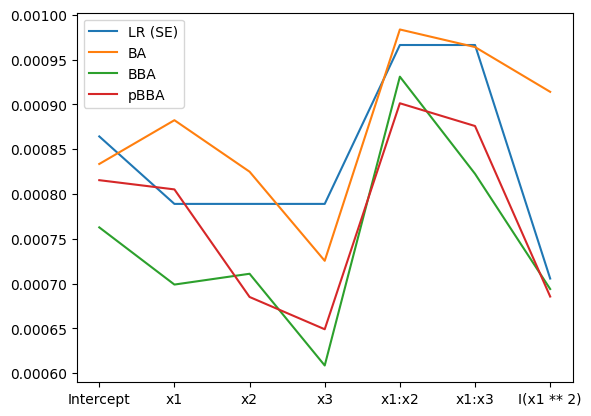

In [22]:
# resample_BA.agg(['mean', 'std']).transpose()
pd.DataFrame({
    'LR (SE)': buildModel(result, formula_int).bse, #*np.sqrt(5),
    'BA': resample_BA_int.agg(['mean', 'std']).transpose()['std'],
    'BBA': resample_BBA_int.agg(['mean', 'std']).transpose()['std'],
    'pBA': resample_pBA.agg(['mean', 'std']).transpose()['std'],
    'pBBA': resample_pBBA_int.agg(['mean', 'std']).transpose()['std'],
}).plot()

seconds ~ x1+x2+x3+x4


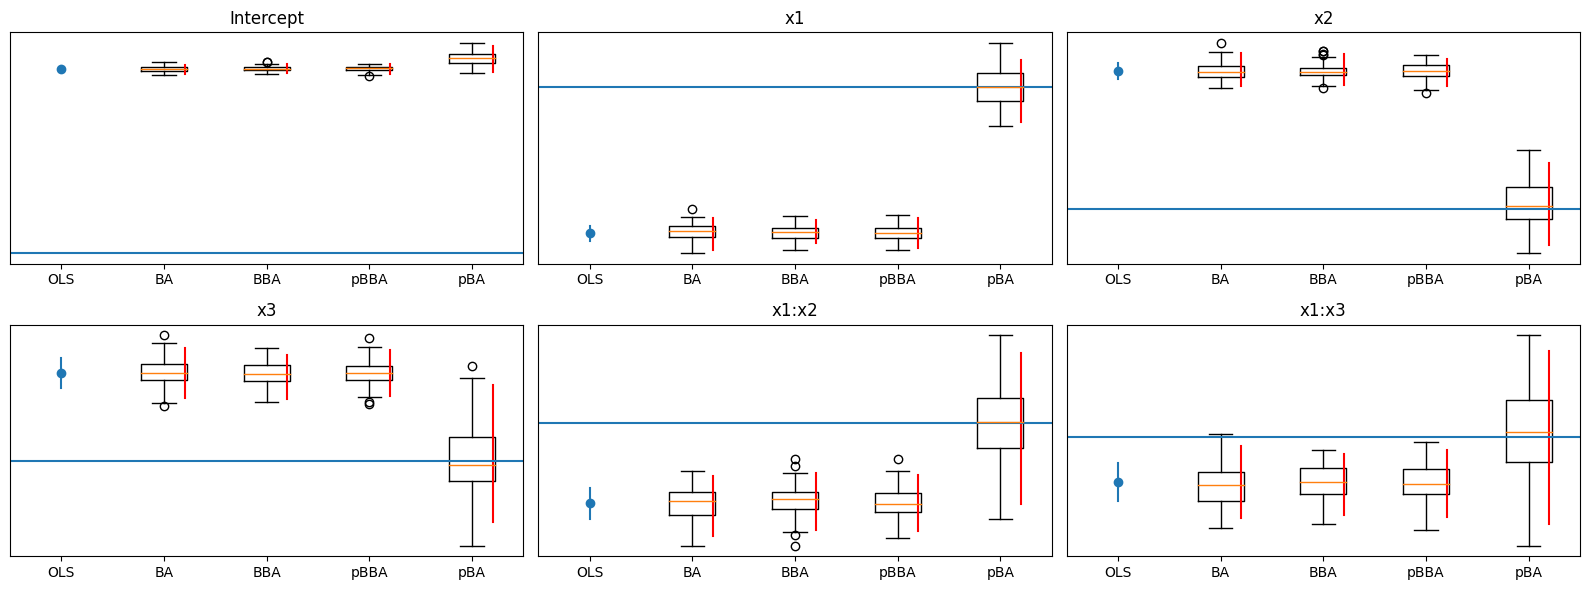

In [26]:
print(formula)
import itertools
ols_model = buildModel(result, formula_int)
terms = list(ols_model.params.index)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=len(terms) // 2, nrows=2, figsize=[16, 6])
# fig, axes = plt.subplots(ncols=len(terms), nrows=1, figsize=[16, 6])
for ax, term in zip(itertools.chain(*axes), terms):
# for ax, term in zip(axes, terms):
    ax.plot([0, 0], [ols_model.params[term] - ols_model.bse[term], ols_model.params[term] + ols_model.bse[term]])
    ax.scatter(0, ols_model.params[term], )
    ax.boxplot([resample_BA_int[term], resample_BBA_int[term], resample_pBBA_int[term], resample_pBA_int[term]])
    ax.plot([1.2, 1.2], resample_BA_int[term].quantile([0.025, 0.975]), color='red')
    ax.plot([2.2, 2.2], resample_BBA_int[term].quantile([0.025, 0.975]), color='red')
    ax.plot([3.2, 3.2], resample_pBBA_int[term].quantile([0.025, 0.975]), color='red')
    ax.plot([4.2, 4.2], resample_pBA_int[term].quantile([0.025, 0.975]), color='red')
    ax.set_title(term)
    ax.get_yaxis().set_visible(False)
    ax.set_xticks([0, 1, 2, 3, 4], ['OLS', 'BA', 'BBA', 'pBBA', 'pBA'])
    ax.set_xlim(-0.5, 4.5)
    ax.axhline(0)
plt.tight_layout()
plt.show()